# Line plot with ReconstructOrder

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tifffile as tf

import os
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [2]:
def nanRobustBlur(I, dim):
    V=I.copy()
    V[I!=I]=0
    VV=cv2.blur(V,dim)   
    W=0*I.copy()+1
    W[I!=I]=0
    WW=cv2.blur(W,dim)    
    Z=VV/WW
    return Z 

In [3]:
def return_uv(img,
                     orientation,
                     anisotropy=1,
                     spacing=20,
                     window=20,
                     linelength=20,
                     linewidth=3,
                     linecolor='g',
                     colorOrient=True,
                     cmapOrient='hsv',
                     threshold=None,
                     alpha=1,
                     clim=[None, None],
                     cmapImage='gray',
                     showPlot=True):
    # Compute U, V such that they are as long as line-length when anisotropy = 1.
    U, V =  anisotropy*linelength * np.cos(2 * orientation), anisotropy*linelength * np.sin(2 * orientation)
    USmooth = nanRobustBlur(U, (window, window)) # plot smoothed vector field
    VSmooth = nanRobustBlur(V, (window, window)) # plot smoothed vector field
    azimuthSmooth = (0.5*np.arctan2(VSmooth,USmooth)) % np.pi
    RSmooth = np.sqrt(USmooth**2+VSmooth**2)
    USmooth, VSmooth = RSmooth*np.cos(azimuthSmooth), RSmooth*np.sin(azimuthSmooth)
    
    return USmooth, VSmooth

In [15]:
def plot_vectorfield(img,
                     orientation,
                     anisotropy=1,
                     spacing=20,
                     window=20,
                     linelength=20,
                     linewidth=3,
                     linecolor='g',
                     colorOrient=True,
                     cmapOrient='hsv',
                     threshold=None,
                     alpha=1,
                     clim=[None, None],
                     cmapImage='gray',
                     showPlot=True):
    """Overlays orientation field on the image. Returns matplotlib image axes.

    Options:
        threshold:
        colorOrient: if it is True, then color the lines by their orientation.
        linelength : can be a scalar or an image the same size as the orientation.
    Parameters
    ----------
    img: nparray
        image to overlay orientation lines on
    orientation: nparray
        orientation in radian
    anisotropy: nparray
    spacing: int

    window: int
    linelength: int
        can be a scalar or an image the same size as the orientation
    linewidth: int
        width of the orientation line
    linecolor: str
    colorOrient: bool
        if it is True, then color the lines by their orientation.
    cmapOrient:
    threshold: nparray
        a binary numpy array, wherever the map is 0, ignore the plotting of the line
    alpha: int
        line transparency. [0,1]. lower is more transparent
    clim: list
        [min, max], min and max intensities for displaying img
    cmapImage:
        colormap for displaying the image
    Returns
    -------
    im_ax: obj
        matplotlib image axes
    """

    # plot vector field representaiton of the orientation map
    
    # Compute U, V such that they are as long as line-length when anisotropy = 1.
    U, V =  anisotropy*linelength * np.cos(2 * orientation), anisotropy*linelength * np.sin(2 * orientation)
    USmooth = nanRobustBlur(U, (window, window)) # plot smoothed vector field
    VSmooth = nanRobustBlur(V, (window, window)) # plot smoothed vector field
    azimuthSmooth = (0.5*np.arctan2(VSmooth,USmooth)) % np.pi
    RSmooth = np.sqrt(USmooth**2+VSmooth**2)
    USmooth, VSmooth = RSmooth*np.cos(azimuthSmooth), RSmooth*np.sin(azimuthSmooth)

    nY, nX = img.shape
    Y, X = np.mgrid[0:nY,0:nX] # notice the reversed order of X and Y
    
    # Sample variables at the specified spacing.
    Plotting_X = X[::spacing, ::spacing]
    Plotting_Y = Y[::spacing, ::spacing]
    Plotting_U = linelength * USmooth[::spacing, ::spacing]
    Plotting_V = linelength * VSmooth[::spacing, ::spacing]
    Plotting_R = RSmooth[::spacing, ::spacing]

    # Threshold the vector lines if specified.
    if threshold is None:
        threshold = np.ones_like(X) # no threshold
    Plotting_thres = threshold[::spacing, ::spacing]
    Plotting_orient=azimuthSmooth[::spacing, ::spacing]

    thresholdIdx = Plotting_thres==1

    Plotting_X=Plotting_X[thresholdIdx]
    Plotting_Y=Plotting_Y[thresholdIdx]
    Plotting_U=Plotting_U[thresholdIdx]
    Plotting_V=Plotting_V[thresholdIdx]
    Plotting_orient=Plotting_orient[thresholdIdx]
    Plotting_R=Plotting_R[thresholdIdx]
    Plotting_color=Plotting_orient * (180/np.pi)
    
    print(Plotting_X)

    if showPlot:
        if colorOrient:
            im_ax = plt.imshow(img, cmap=cmapImage, vmin=clim[0], vmax=clim[1])
            plt.title('Orientation')
            plt.quiver(Plotting_X, Plotting_Y,
                       Plotting_U, Plotting_V, Plotting_color,
                       cmap=cmapOrient,
                       edgecolor=linecolor, facecolor=linecolor, units='xy', alpha=alpha, width=linewidth,
                       headwidth=0, headlength=0, headaxislength=0,
                       scale_units = 'xy', scale = 1, angles = 'uv', pivot = 'mid')
        else:
            im_ax = plt.imshow(img, cmap=cmapImage, vmin=clim[0], vmax=clim[1])
            plt.title('Orientation')
            plt.quiver(Plotting_X, Plotting_Y,
                       Plotting_U, Plotting_V,
                       edgecolor=linecolor,facecolor=linecolor,units='xy', alpha=alpha, width=linewidth,
                       headwidth = 0, headlength = 0, headaxislength = 0,
                       scale_units = 'xy',scale = 1, angles = 'uv', pivot = 'mid')
    else:
        im_ax=None

In [16]:
Ret_Kazansky = tf.imread('Kazansky_525_retardance.ome.tif')
Ori_Kazansky = tf.imread('kazansky_525_orientation.ome.tif')

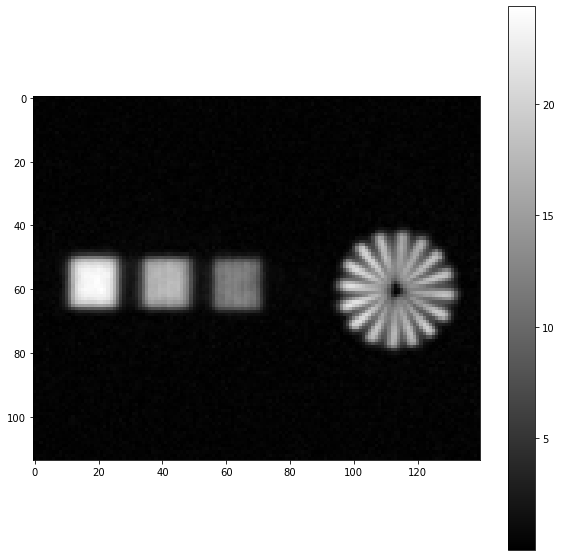

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(Ret_Kazansky, cmap='gray')
plt.colorbar()

[  0   2   4 ... 134 136 138]


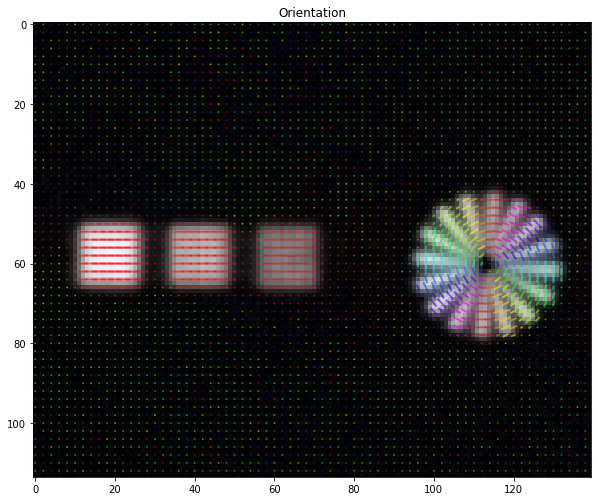

In [18]:
spacing = 2

plt.figure(figsize=(10,10))
plot_vectorfield(Ret_Kazansky, Ori_Kazansky,\
                 anisotropy=Ret_Kazansky*0.04, \
                 spacing=spacing,
                 window=spacing,
                 linelength=spacing,
                 linewidth=0.5,
                 linecolor='g',
                 colorOrient=True,
                 cmapOrient='hsv',
                 threshold=None,
                 alpha=0.6,
                 clim=[0, 25],
                 cmapImage='gray',
                 showPlot=True,)
# plt.savefig('Kazansky_line_color.png',dpi=450)

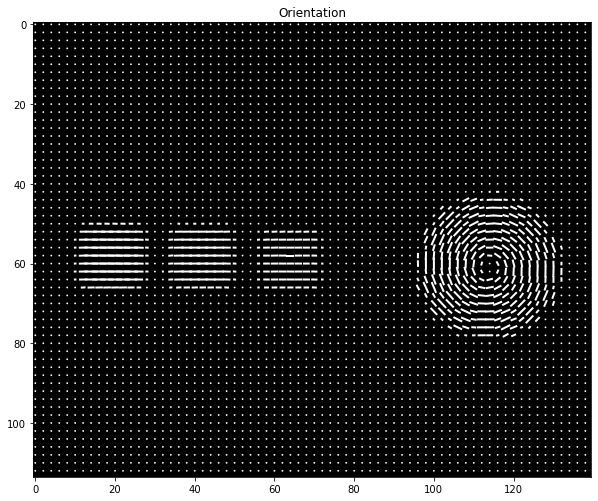

In [90]:
spacing = 2

plt.figure(figsize=(10,10))
plot_vectorfield(np.zeros_like(Ret_Kazansky), Ori_Kazansky,\
                 anisotropy=Ret_Kazansky*0.04, \
                 spacing=spacing,
                 window=spacing,
                 linelength=spacing,
                 linewidth=0.5,
                 linecolor='w',
                 colorOrient=False,
                 cmapOrient='hsv',
                 threshold=None,
                 alpha=1,
                 clim=[0, 25],
                 cmapImage='gray',
                 showPlot=True,)
# plt.savefig('Kazansky_line_white.png',dpi=450)

In [ ]:
Ret_Brain = tf.imread('Brain_525_retardance.ome.tif')
Ori_Brain = tf.imread('Brain_525_orientation.ome.tif')

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(Ret_Brain, cmap='gray')
plt.colorbar()

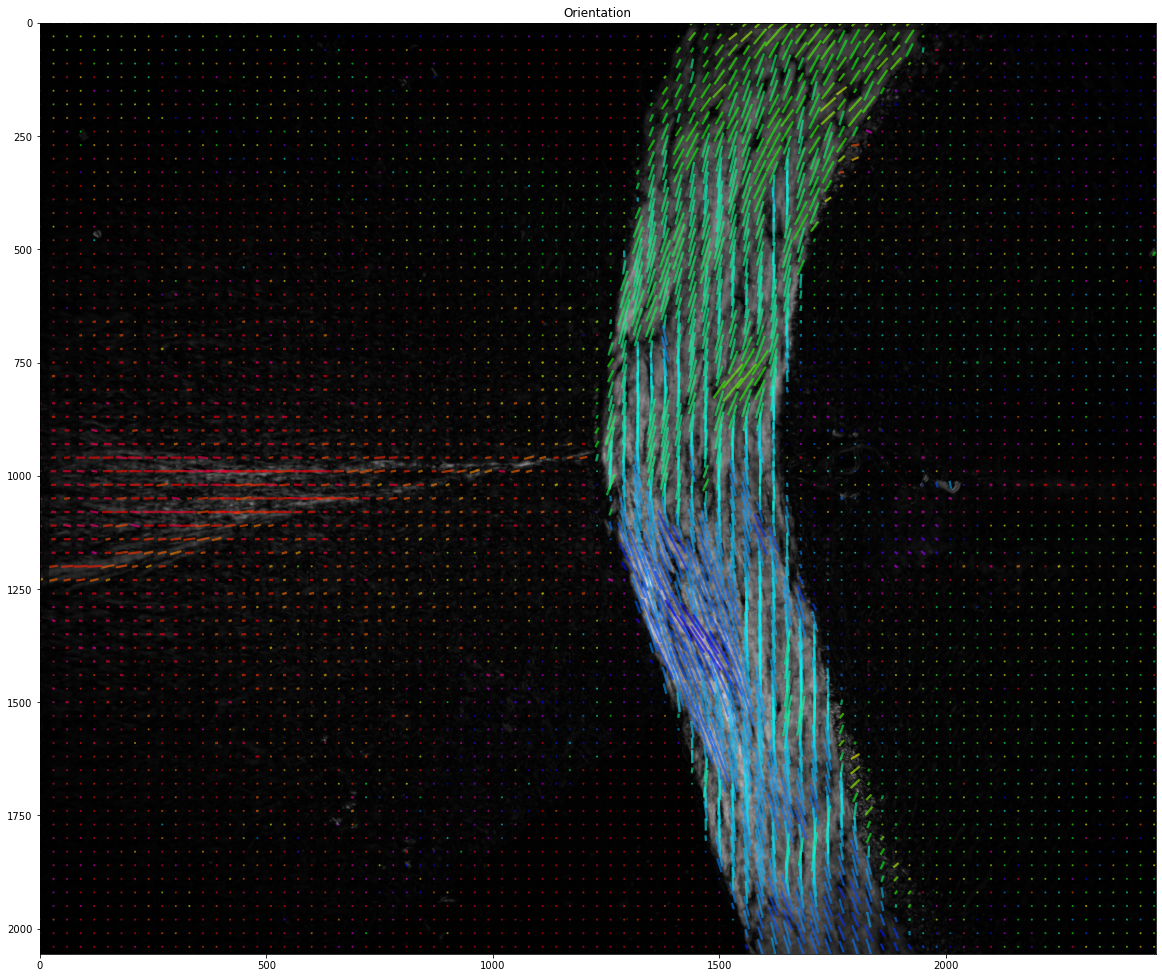

In [44]:
spacing = 30

plt.figure(figsize=(20,20))
plot_vectorfield(Ret_Brain, Ori_Brain,\
                 anisotropy=Ret_Brain*0.004, \
                 spacing=spacing,
                 window=spacing,
                 linelength=spacing,
                 linewidth=5,
                 linecolor='g',
                 colorOrient=True,
                 cmapOrient='hsv',
                 threshold=None,
                 alpha=0.6,
                 clim=[0, 60],
                 cmapImage='gray',
                 showPlot=True)
# plt.savefig('Mouse_brain_line_color.png',dpi=300)

In [ ]:
spacing = 30

plt.figure(figsize=(20,20))
plot_vectorfield(np.zeros_like(Ret_Brain), Ori_Brain,\
                 anisotropy=Ret_Brain*0.004, \
                 spacing=spacing,
                 window=spacing,
                 linelength=spacing,
                 linewidth=5,
                 linecolor='w',
                 colorOrient=False,
                 cmapOrient='hsv',
                 threshold=None,
                 alpha=1,
                 clim=[0, 60],
                 cmapImage='gray',
                 showPlot=True,)
# plt.savefig('Mouse_brain_line_white.png',dpi=300)

In [45]:
import lic

In [46]:
Ret_Kazansky = tf.imread('Kazansky_525_retardance.ome.tif')
Ori_Kazansky = tf.imread('kazansky_525_orientation.ome.tif')

In [51]:
img = Ret_Kazansky
orientation = Ori_Kazansky
anisotropy = Ret_Kazansky*0.04
spacing = 2
window = spacing,
linelength = spacing
linewidth=0.5,
linecolor='g',
colorOrient=True,
cmapOrient='hsv',
threshold=None,
alpha=0.6,
clim=[0, 25],
cmapImage='gray',
showPlot=True

In [52]:
USmooth, VSmooth = return_uv(Ret_Kazansky, Ori_Kazansky,\
                 anisotropy=Ret_Kazansky*0.04, \
                 spacing=spacing,
                 window=spacing,
                 linelength=spacing,
                 linewidth=0.5,
                 linecolor='g',
                 colorOrient=True,
                 cmapOrient='hsv',
                 threshold=None,
                 alpha=0.6,
                 clim=[0, 25],
                 cmapImage='gray',
                 showPlot=True,)

In [53]:
lic_result = lic.lic(USmooth, VSmooth, length=30)

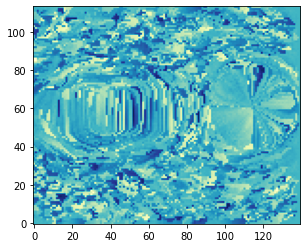

In [54]:
plt.imshow(lic_result, origin='lower', cmap='YlGnBu')
plt.show()

In [180]:
Ret_Brain = tf.imread('Brain_525_retardance.ome.tif')
Ori_Brain = tf.imread('Brain_525_orientation.ome.tif')

In [181]:
USmooth, VSmooth = return_uv(Ret_Brain, Ori_Brain,\
                 anisotropy=Ret_Brain*0.004, \
                 spacing=spacing,
                 window=spacing,
                 linelength=spacing,
                 linewidth=5,
                 linecolor='g',
                 colorOrient=True,
                 cmapOrient='hsv',
                 threshold=None,
                 alpha=0.6,
                 clim=[0, 60],
                 cmapImage='gray',
                 showPlot=True)

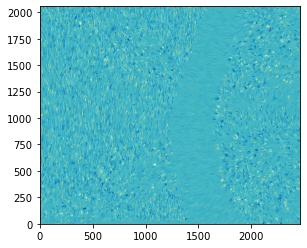

In [43]:
lic_result = lic.lic(USmooth, VSmooth, length=50)
plt.imshow(lic_result, origin='lower', cmap='YlGnBu')
plt.show()

In [186]:
def plot_streamplot(img,
                     orientation,
                     anisotropy=1,
                     spacing=20,
                     window=20,
                     linelength=20,
                     linewidth=3,
                     linecolor='g',
                     colorOrient=True,
                     cmapOrient='hsv',
                     threshold=None,
                     alpha=1,
                     clim=[None, None],
                     cmapImage='gray',
                     showPlot=True):

    # plot vector field representaiton of the orientation map
    
    # Compute U, V such that they are as long as line-length when anisotropy = 1.
    U, V =  anisotropy*linelength * np.cos(2 * orientation), anisotropy*linelength * np.sin(2 * orientation)
    USmooth = nanRobustBlur(U, (window, window)) # plot smoothed vector field
    VSmooth = nanRobustBlur(V, (window, window)) # plot smoothed vector field
    azimuthSmooth = (0.5*np.arctan2(VSmooth,USmooth)) % np.pi
    RSmooth = np.sqrt(USmooth**2+VSmooth**2)
    USmooth, VSmooth = RSmooth*np.cos(azimuthSmooth), RSmooth*np.sin(azimuthSmooth)

    nY, nX = img.shape
    Y, X = np.mgrid[0:nY,0:nX] # notice the reversed order of X and Y
#     print(Y, X)
    
    # Sample variables at the specified spacing.
    Plotting_X = X[::spacing, ::spacing]
    Plotting_Y = Y[::spacing, ::spacing]
    Plotting_U = linelength * USmooth[::spacing, ::spacing]
    Plotting_V = linelength * VSmooth[::spacing, ::spacing]
    Plotting_R = RSmooth[::spacing, ::spacing]
    

    # Threshold the vector lines if specified.
    if threshold is None:
        threshold = np.ones_like(X) # no threshold
    Plotting_thres = threshold[::spacing, ::spacing]
    Plotting_orient=azimuthSmooth[::spacing, ::spacing]

    thresholdIdx = Plotting_thres==1
    print(Plotting_Y)
    
#     Plotting_X=Plotting_X[thresholdIdx]
#     Plotting_Y=Plotting_Y[thresholdIdx]
#     Plotting_U=Plotting_U[thresholdIdx]
#     Plotting_V=Plotting_V[thresholdIdx]
#     Plotting_orient=Plotting_orient[thresholdIdx]
#     Plotting_R=Plotting_R[thresholdIdx]
    Plotting_color=Plotting_orient * (180/np.pi)

    if showPlot:
        if colorOrient:
            im_ax = plt.imshow(img, cmap=cmapImage, vmin=clim[0], vmax=clim[1])
            plt.title('Orientation')
            plt.streamplot(Plotting_X, Plotting_Y,
                       Plotting_U, Plotting_V, density=2, color=linecolor, cmap=cmapOrient,
                       norm=True)
        else:
            im_ax = plt.imshow(img, cmap=cmapImage, vmin=clim[0], vmax=clim[1])
            plt.title('Orientation')
            plt.streamplot(Plotting_X, Plotting_Y,
                       Plotting_U, Plotting_V,
                       edgecolor=linecolor,facecolor=linecolor,units='xy', alpha=alpha, width=linewidth,
                       headwidth = 0, headlength = 0, headaxislength = 0,
                       scale_units = 'xy',scale = 1, angles = 'uv', pivot = 'mid')
    else:
        im_ax=None

[[  0   0   0 ...   0   0   0]
 [  2   2   2 ...   2   2   2]
 [  4   4   4 ...   4   4   4]
 ...
 [294 294 294 ... 294 294 294]
 [296 296 296 ... 296 296 296]
 [298 298 298 ... 298 298 298]]


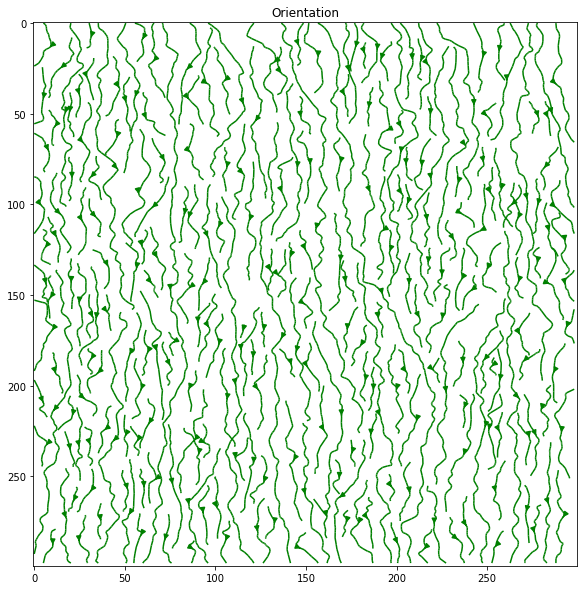

In [187]:
spacing = 2

plt.figure(figsize=(10,10))
plot_streamplot(Ret_Kazansky, Ori_Kazansky,\
                 anisotropy=Ret_Kazansky*0.04, \
                 spacing=spacing,
                 window=spacing,
                 linelength=spacing,
                 linewidth=0.5,
                 linecolor='g',
                 colorOrient=True,
                 cmapOrient='hsv',
                 threshold=None,
                 alpha=0.6,
                 clim=[0, 25],
                 cmapImage='gray',
                 showPlot=True,)

In [188]:
Ret_Kazansky = cv2.imread('img_retardance3D_t000_p000_z044.tif', -1)
Ori_Kazansky = cv2.imread('img_azimuth_t000_p000_z044.tif', -1)

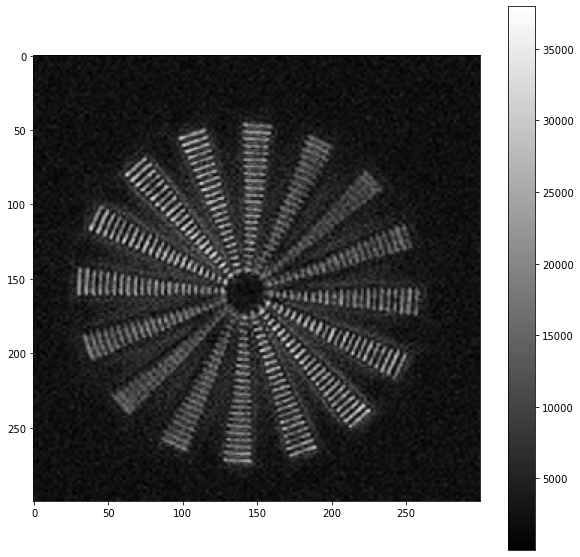

In [189]:
plt.figure(figsize=(10,10))
plt.imshow(Ret_Kazansky, cmap='gray')
plt.colorbar()

[[  0   2   4 ... 294 296 298]
 [  0   2   4 ... 294 296 298]
 [  0   2   4 ... 294 296 298]
 ...
 [  0   2   4 ... 294 296 298]
 [  0   2   4 ... 294 296 298]
 [  0   2   4 ... 294 296 298]]


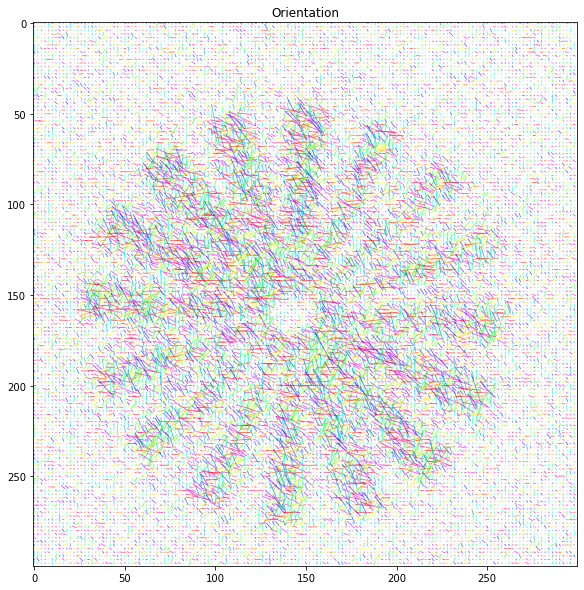

In [195]:
spacing = 2

plt.figure(figsize=(10,10))
plot_vectorfield(Ret_Kazansky, Ori_Kazansky,\
                 anisotropy=Ret_Kazansky*0.004, \
                 spacing=spacing,
                 window=spacing,
                 linelength=0.5,
                 linewidth=0.5,
                 linecolor='g',
                 colorOrient=True,
                 cmapOrient='hsv',
                 threshold=None,
                 alpha=0.6,
                 clim=[0, 25],
                 cmapImage='gray',
                 showPlot=True,)
# plt.savefig('Kazansky_line_color.png',dpi=450)

[[  0   0   0 ...   0   0   0]
 [  2   2   2 ...   2   2   2]
 [  4   4   4 ...   4   4   4]
 ...
 [294 294 294 ... 294 294 294]
 [296 296 296 ... 296 296 296]
 [298 298 298 ... 298 298 298]]


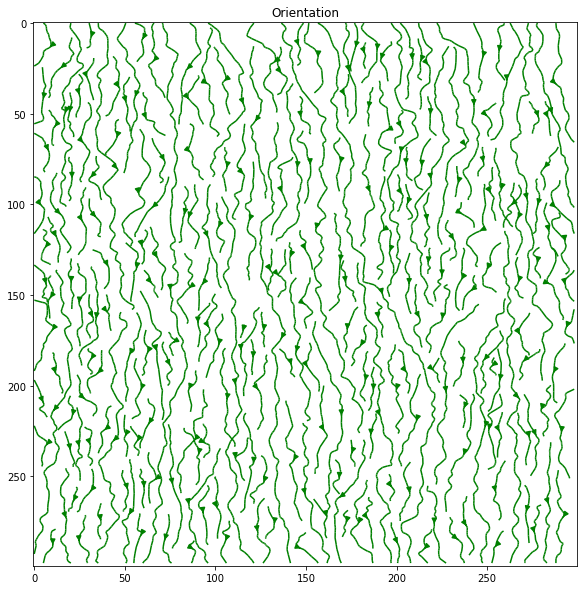

In [191]:
spacing = 2

plt.figure(figsize=(10,10))
plot_streamplot(Ret_Kazansky, Ori_Kazansky,\
                 anisotropy=Ret_Kazansky*0.04, \
                 spacing=spacing,
                 window=spacing,
                 linelength=1,
                 linewidth=1,
                 linecolor='g',
                 colorOrient=True,
                 cmapOrient='hsv',
                 threshold=None,
                 alpha=0.6,
                 clim=[0, 5],
                 cmapImage='gray',
                 showPlot=True,)